In [69]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# 7 Prediction

## 7.1 The Boston Bruins problem

In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks. Boston lost the first two games 0-1 and 2-3, then won
the next two games 8-1 and 4-0. At this point in the series, what is the
probability that Boston will win the next game, and what is their
probability of winning the championship?

As always, to answer a question like this, we need to make some
assumptions. First, it is reasonable to believe that goal scoring in
hockey is at least approximately a Poisson process, which means that it
is equally likely for a goal to be scored at any time during a game.
Second, we can assume that against a particular opponent, each team has
some long-term average goals per game, denoted $\lambda$.

Given these assumptions, my strategy for answering this question is

1.  Use statistics from previous games to choose a prior distribution
    for $\lambda$.

2.  Use the score from the first four games to estimate $\lambda$ for
    each team.

3.  Use the posterior distributions of $\lambda$ to compute distribution
    of goals for each team, the distribution of the goal differential,
    and the probability that each team wins the next game.

4.  Compute the probability that each team wins the series.

To choose a prior distribution, I got some statistics from
<http://www.nhl.com>, specifically the average goals per game for each
team in the 2010-11 season. The distribution is roughly Gaussian with
mean 2.8 and standard deviation 0.3.

The Gaussian distribution is continuous, but we’ll approximate it with a
discrete PMF. 

In [70]:
mu=2.8
std=0.3
num_sigmas=4
n=101

low  = mu-num_sigmas*std
high = mu+num_sigmas*std

lam_hypos_xk = np.linspace(low,high,n)

goals_prior_rv=stats.norm(loc=mu, scale=std)
goals_prior_pmf = goals_prior_rv.pdf(lam_hypos_xk)
goals_prior_pmf = goals_prior_pmf / goals_prior_pmf.sum()

`mu` and `sigma` are the mean and standard
deviation of the Gaussian distribution. `num_sigmas` is the number of
standard deviations above and below the mean that the PMF will span, and
`n` is the number of values in the PMF.

Again we use `numpy.linspace` to make an array of
`n` equally spaced values between `low` and
`high`, including both.

`norm.pdf` evaluates the Gaussian probability density function (PDF).

So the prior distribution is Gaussian with mean 2.8, standard deviation
0.3, and it spans 4 sigmas above and below the mean.

As always, we have to decide how to represent each hypothesis; in this
case I represent the hypothesis that $\lambda=x$ with the floating-point
value `x`.

## 7.2 Poisson processes

In mathematical statistics, a **process** is a stochastic
model of a physical system (“stochastic” means that the model has some
kind of randomness in it). For example, a Bernoulli process is a model
of a sequence of events, called trials, in which each trial has two
possible outcomes, like success and failure. So a Bernoulli process is a
natural model for a series of coin flips, or a series of shots on goal.

A Poisson process is the continuous version of a Bernoulli process,
where an event can occur at any point in time with equal probability.
Poisson processes can be used to model customers arriving in a store,
buses arriving at a bus stop, or goals scored in a hockey game.

In many real systems the probability of an event changes over time.
Customers are more likely to go to a store at certain times of day,
buses are supposed to arrive at fixed intervals, and goals are more or
less likely at different times during a game.

But all models are based on simplifications, and in this case modeling a
hockey game with a Poisson process is a reasonable choice. Heuer, Müller
and Rubner (2010) analyze scoring in a German soccer league and come to
the same conclusion; see
<http://www.cimat.mx/Eventos/vpec10/img/poisson.pdf>.

The benefit of using this model is that we can compute the distribution
of goals per game efficiently, as well as the distribution of time
between goals. Specifically, if the average number of goals in a game is
`lam`, the distribution of goals per game is given by the
Poisson PMF:

In [71]:
#Example: Poisson random variable with the rate parameter equal to 2
lam=2
poisson_rv=stats.poisson(mu=lam)

And the distribution of time between goals is given by the exponential
PDF:

In [72]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon
expon_rv=stats.expon(scale=1. / lam)

I use the variable `lam` because `lambda` is a
reserved keyword in Python.

## 7.3 The posteriors

Now we can compute the likelihood that a team with a hypothetical value
of `lam` scores `k` goals in a game:

In [73]:
#Exepmlary values
lam=2
k=2
likelihood = stats.poisson.pmf(mu=lam,k=k)

Each hypothesis is a possible value of $\lambda$; `data` is
the observed number of goals, `k`.

With the likelihood function and priors in place, we can perform 
updates for both teams with the scores from the first four games.

In [74]:
def hockey(prior_pmf, hypos_xk, data):
    mg_data,mg_hypos_xk = np.meshgrid(data,hypos_xk)
    _product=(np.hstack((prior_pmf[:,None], stats.poisson.pmf(mu=mg_hypos_xk,k=mg_data) )) ).cumprod(axis=1)
    posterior_pmf=_product/_product.sum(axis=0)
    return posterior_pmf

bruins_data=np.array([0,2,8,4])
canucs_data=np.array([1,3,1,0])

bruins_lam_posterior = hockey(goals_prior_pmf, lam_hypos_xk, bruins_data)
canucs_lam_posterior = hockey(goals_prior_pmf, lam_hypos_xk, canucs_data)

The most likely lam canucs 2.6
The most likely lam bruins 2.9


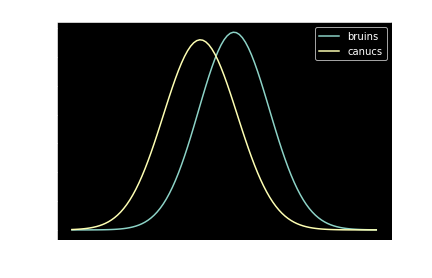

In [75]:
#Figure 7.1
plt.plot(lam_hypos_xk,bruins_lam_posterior[:,-1],label='bruins')
plt.plot(lam_hypos_xk,canucs_lam_posterior[:,-1],label='canucs')
plt.xlabel('Goals per game');
plt.ylabel('Probability');
plt.legend()
plt.title('Figure 7.1: Posterior distribution of the number of goals per game.');

print(f'The most likely lam canucs {lam_hypos_xk[np.argmax(canucs_lam_posterior[:,-1])]:0.1f}')
print(f'The most likely lam bruins {lam_hypos_xk[np.argmax(bruins_lam_posterior[:,-1])]:0.1f}')

Figure 7.1 shows the resulting posterior distributions for
`lam`. Based on the first four games, the most likely values
for `lam` are 2.6 for the Canucks and 2.9 for the Bruins.

## 7.4 The distribution of goals

To compute the probability that each team wins the next game, we need to
compute the distribution of goals for each team.

If we knew the value of `lam` exactly, we could use the
Poisson distribution again. For this purpose `scipy.stats.poisson` can be used 
as was shown above.

To get the distribution of the goals we assume that no more than 10 goals are scored in a game, because the probability of scoring more than 10 goals in a game is quite low.

That’s simple enough so far; the problem is that we don’t know the value
of `lam` exactly. Instead, we have a distribution of possible
values for `lam`.

For each value of `lam`, the distribution of goals is
Poisson. So the overall distribution of goals is a mixture of these
Poisson distributions, weighted according to the probabilities in the
distribution of `lam`.

Given the posterior distribution of `lam`, here’s the code
that makes the distribution of goals:

In [76]:
rng=np.arange(11)
bruins_mixture_pmf=np.zeros_like(rng,dtype=float)
for xval_hypo, prob_bruins in zip(lam_hypos_xk, bruins_lam_posterior[:,-1]):
    bruins_mixture_pmf = bruins_mixture_pmf + stats.poisson.pmf(mu=xval_hypo, k=rng) * prob_bruins
    
canucs_mixture_pmf=np.zeros_like(rng,dtype=float)
for xval_hypo, prob_canucs in zip(lam_hypos_xk, canucs_lam_posterior[:,-1]):
    canucs_mixture_pmf = canucs_mixture_pmf + stats.poisson.pmf(mu=xval_hypo, k=rng) * prob_canucs


For each value of `lam` we make a Poisson Pmf weigh it (see Chapter 6) 
with the posterior probability of this `lam` and add it to the meta-Pmf. 
I call it a meta-Pmf because it is a Pmf that contains Pmfs as its values.

Figure 7.2 shows the resulting distribution of goals for the
Bruins and Canucks. The Bruins are less likely to score 3 goals or fewer
in the next game, and more likely to score 4 or more.

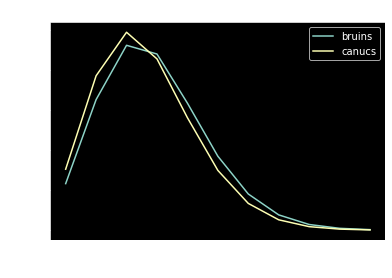

In [77]:
#Figure 7.2
plt.plot(rng,bruins_mixture_pmf,label='bruins')
plt.plot(rng,canucs_mixture_pmf,label='canucs')
plt.xlabel('Goals');
plt.ylabel('Probability');
plt.legend()
plt.title('Figure 7.2: Distribution of goals in a single game.');

Alternatively, one can use `meshgrid` and vectorized calculations for `numpy.array`
to avoid the `for` loops and improve the code efficiency. The resulting distributions of goals are the same.

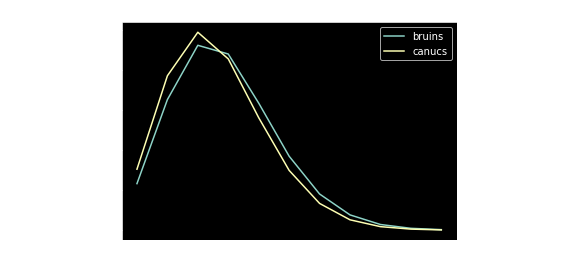

In [78]:
rng_goals=np.arange(11)
mg_rng_goals, mg_lam_hypos_xk = np.meshgrid(rng_goals,lam_hypos_xk)
poisson_dist_pmf=stats.poisson.pmf(mu=mg_lam_hypos_xk, k=mg_rng_goals)

bruins_mixture_pmf = (poisson_dist_pmf * bruins_lam_posterior[:,-1][:,None]).sum(axis=0)
canucs_mixture_pmf = (poisson_dist_pmf * canucs_lam_posterior[:,-1][:,None]).sum(axis=0)

#Figure 7.2
plt.plot(rng,bruins_mixture_pmf,label='bruins')
plt.plot(rng,canucs_mixture_pmf,label='canucs')
plt.xlabel('Goals');
plt.ylabel('Probability');
plt.legend()
plt.title('Figure 7.2: Distribution of goals in a single game using meshgrid and vectorized calculations.');

## 7.5 The probability of winning

To get the probability of winning, first we compute the distribution of
the goal differential:

In [79]:
#finding all combinations
#https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays
#summing probabilities for the same diffs
#https://stackoverflow.com/questions/30003068/get-a-list-of-all-indices-of-repeated-elements-in-a-numpy-array

In [80]:
vals = np.array(np.meshgrid(rng_goals,rng_goals)).T.reshape(-1,2)
vals = np.diff(vals,axis=1)
probs=np.array(np.meshgrid(canucs_mixture_pmf,bruins_mixture_pmf)).T.reshape(-1,2).prod(axis=1)

sorted_index=vals.argsort(axis=0)
vals=vals[sorted_index]
probs=probs[sorted_index]

uvals, idx, counts = np.unique(vals,return_counts=True,return_index=True)

difference_pmf = np.array([i.sum() for i in np.split(probs,idx[1:])])
# idx[1:] as split make the first interval from [:1]
# see https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html

Subtracting two distributions is almost the same as adding, which we saw in Chapter 5.

If the goal differential is positive, the Bruins win; if negative, the
Canucks win; if 0, it’s a tie:

In [81]:
p_tie = difference_pmf[uvals==0][0]
p_win = difference_pmf[uvals>0].sum()
p_loose = difference_pmf[uvals<0].sum()

print(f"prob bruins win {p_win:0.2f}")
print(f"prob bruins loose {p_loose:0.2f}")
print(f"prob tie {p_tie :0.2f}")

prob bruins win 0.46
prob bruins loose 0.37
prob tie 0.17


With the distributions from the previous section, `p_win` is 46%,
`p_loss` is 37%, and `p_tie` is 17%.

In the event of a tie at the end of “regulation play,” the teams play
overtime periods until one team scores. Since the game ends immediately
when the first goal is scored, this overtime format is known as “sudden
death.”

## 7.6 Sudden death

To compute the probability of winning in a sudden death overtime, the
important statistic is not goals per game, but time until the first
goal. The assumption that goal-scoring is a Poisson process implies that
the time between goals is exponentially distributed.

Given `lam`, we can compute the time between goals using `scipy.stats.expon`.

The upper bound of the distribution is assumed to be 2,
because the probability of going more than two games without
scoring is small. 101 is the number of values in the Pmf.

If we know `lam` exactly, that’s all there is to it. But we
don’t; instead we have a posterior distribution of possible values. So
as we did with the distribution of goals, we make a meta-Pmf and compute
a mixture of Pmfs.

In [82]:
rng_expon=np.linspace(0.001,2,2001)
mg_rng_expon, mg_lam_hypos_xk = np.meshgrid(rng_expon,lam_hypos_xk)
expon_dist_probs_pmf=stats.expon.pdf(x=mg_rng_expon, scale=1. / mg_lam_hypos_xk)
expon_dist_probs_pmf=expon_dist_probs_pmf/expon_dist_probs_pmf.sum(axis=1)[:,None]

pmf_goal_time_mixture_bruins = (expon_dist_probs_pmf * bruins_lam_posterior[:,-1][:,None]).sum(axis=0)
pmf_goal_time_mixture_canucs = (expon_dist_probs_pmf * canucs_lam_posterior[:,-1][:,None]).sum(axis=0)

Figure 7.3 shows the resulting distributions. For time values
less than one period (one third of a game), the Bruins are more likely
to score. The time until the Canucks score is more likely to be longer.

I set the number of values, `n`, fairly high in order to
minimize the number of ties, since it is not possible for both teams to
score simultaneously.

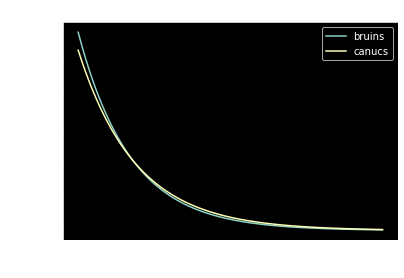

In [83]:
#Figure 7.3
plt.plot(rng_expon,pmf_goal_time_mixture_bruins,label='bruins')
plt.plot(rng_expon,pmf_goal_time_mixture_canucs,label='canucs')
plt.xlabel('Games until goal');
plt.ylabel('Probability');
plt.legend()
plt.title('Figure 7.3: Distribution of time between goals.');

Now we compute the probability that the Bruins score first:

In [84]:
mg_rng_expon_bruins, mg_rng_expon_canucs = np.meshgrid(rng_expon, rng_expon)
mg_pmf_mixture_bruins,mg_pmf_mixture_canucs = np.meshgrid(pmf_goal_time_mixture_bruins, pmf_goal_time_mixture_canucs)

idx = mg_rng_expon_bruins < mg_rng_expon_canucs
p_overtime = (mg_pmf_mixture_bruins[idx]* mg_pmf_mixture_canucs[idx]).sum().sum()
print(f"probability the time for goal in overtime is smaller bor bruins {p_overtime:0.2f}")

probability the time for goal in overtime is smaller bor bruins 0.52


For the Bruins, the probability of winning in overtime is 52%.

Finally, the total probability of winning is the chance of winning at
the end of regulation play plus the probability of winning in overtime.

In [87]:
p_win_game= p_win + p_tie*p_overtime
print(f"probability of bruins winning the next game {p_win_game:0.2f}")

probability of bruins winning the next game 0.55


For the Bruins, the overall chance of winning the next game is 55%.

To win the series, the Bruins can either win the next two games or split
the next two and win the third. Again, we can compute the total
probability:

In [88]:
#win the next two
p_series = p_win_game**2

#split the next two (win 1 loose 2 or loose 1 win 1) and win the third
p_series = p_series + 2 * p_win_game * (1-p_win_game) *p_win_game
print(f"probability of bruins winning the series {p_series:0.2f}")

probability of bruins winning the series 0.57


The Bruins chance of winning the series is 57%. And in 2011, they did.

## 7.7 Discussion

As always, the analysis in this chapter is based on modeling decisions,
and modeling is almost always an iterative process. In general, you want
to start with something simple that yields an approximate answer,
identify likely sources of error, and look for opportunities for
improvement.

In this example, I would consider these options:

-   I chose a prior based on the average goals per game for each team.
    But this statistic is averaged across all opponents. Against a
    particular opponent, we might expect more variability. For example,
    if the team with the best offense plays the team with the worst
    defense, the expected goals per game might be several standard
    deviations above the mean.

-   For data I used only the first four games of the championship
    series. If the same teams played each other during the regular
    season, I could use the results from those games as well. One
    complication is that the composition of teams changes during the
    season due to trades and injuries. So it might be best to give more
    weight to recent games.

-   To take advantage of all available information, we could use results
    from all regular season games to estimate each team’s goal scoring
    rate, possibly adjusted by estimating an additional factor for each
    pairwise match-up. This approach would be more complicated, but it
    is still feasible.

For the first option, we could use the results from the regular season
to estimate the variability across all pairwise match-ups. Thanks to
Dirk Hoag at <http://forechecker.blogspot.com/>, I was able to get the
number of goals scored during regulation play (not overtime) for each
game in the regular season.

Teams in different conferences only play each other one or two times in
the regular season, so I focused on pairs that played each other 4–6
times. For each pair, I computed the average goals per game, which is an
estimate of $\lambda$, then plotted the distribution of these estimates.

The mean of these estimates is 2.8, again, but the standard deviation is
0.85, substantially higher than what we got computing one estimate for
each team.

If we run the analysis again with the higher-variance prior, the
probability that the Bruins win the series is 80%, substantially higher
than the result with the low-variance prior, 57%.

So it turns out that the results are sensitive to the prior, which makes
sense considering how little data we have to work with. Based on the
difference between the low-variance model and the high-variable model,
it seems worthwhile to put some effort into getting the prior right.

The code and data for this chapter are available from
<http://thinkbayes.com/hockey.py> and
<http://thinkbayes.com/hockey_data.csv>. For more information see
Section [download].

## 7.8 Exercises

If buses arrive at a bus stop every 20 minutes, and you arrive at the
bus stop at a random time, your wait time until the bus arrives is
uniformly distributed from 0 to 20 minutes.

But in reality, there is variability in the time between buses. Suppose
you are waiting for a bus, and you know the historical distribution of
time between buses. Compute your distribution of wait times.

Hint: Suppose that the time between buses is either 5 or 10 minutes with
equal probability. What is the probability that you arrive during one of
the 10 minute intervals?

I solve a version of this problem in the next chapter.

Suppose that passengers arriving at the bus stop are well-modeled by a
Poisson process with parameter $\lambda$. If you arrive at the stop and
find 3 people waiting, what is your posterior distribution for the time
since the last bus arrived.

I solve a version of this problem in the next chapter.

Suppose that you are an ecologist sampling the insect population in a
new environment. You deploy 100 traps in a test area and come back the
next day to check on them. You find that 37 traps have been triggered,
trapping an insect inside. Once a trap triggers, it cannot trap another
insect until it has been reset.

If you reset the traps and come back in two days, how many traps do you
expect to find triggered? Compute a posterior predictive distribution
for the number of traps.

Suppose you are the manager of an apartment building with 100 light
bulbs in common areas. It is your responsibility to replace light bulbs
when they break.

On January 1, all 100 bulbs are working. When you inspect them on
February 1, you find 3 light bulbs out. If you come back on April 1, how
many light bulbs do you expect to find broken?

In the previous exercise, you could reasonably assume that an event is
equally likely at any time. For light bulbs, the likelihood of failure
depends on the age of the bulb. Specifically, old bulbs have an
increasing failure rate due to evaporation of the filament.

This problem is more open-ended than some; you will have to make
modeling decisions. You might want to read about the Weibull
distribution (<http://en.wikipedia.org/wiki/Weibull_distribution>). Or
you might want to look around for information about light bulb survival
curves.